# Simple Radar

In [1]:
import pamtra2
import collections
import refractiveIndex
import numpy as np
import pandas as pn
import xarray as xr
from collections import OrderedDict
from copy import deepcopy, copy
import toolz
import collections
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except:
    pass

In [2]:
import pyPamtraRadarSimulator



# create Profile

In [28]:
additionalDims = collections.OrderedDict()
nHeights = 1
# nHeights = 2

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=['cloud'],
    additionalDims = additionalDims,
    frequencies = [3e9],
)


In [29]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 1, hydrometeor: 1, layer: 10)
Coordinates:
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U5 'cloud'
  * frequency            (frequency) float64 3e+09
Data variables:
    height               (layer) float64 nan nan nan nan nan nan nan nan nan nan
    temperature          (layer) float64 nan nan nan nan nan nan nan nan nan nan
    pressure             (layer) float64 nan nan nan nan nan nan nan nan nan nan
    relativeHumidity     (layer) float64 nan nan nan nan nan nan nan nan nan nan
    horizontalWind       (layer) float64 nan nan nan nan nan nan nan nan nan nan
    verticalWind         (layer) float64 nan nan nan nan nan nan nan nan nan nan
    eddyDissipationRate  (layer) float64 nan nan nan nan nan nan nan nan nan nan
    waterContent         (layer, hydrometeor) float64 nan nan nan nan nan ...
    wavelength           (frequency) float64 0.09993

Fill with some dummie values

In [30]:

pam2.profile.height[:] = np.linspace(100,1000,nHeights)
pam2.profile.temperature[:] = 250 
pam2.profile.relativeHumidity[:] = 90
pam2.profile.pressure[:] = 100000
pam2.profile.eddyDissipationRate[:] = 1e-3
pam2.profile.horizontalWind[:] = 10



For testing, dask arrays are turned on by chunking.

In [31]:
# pam2.profile = pam2.profile.chunk({'layer':1, 'frequency':1})


pam2.profile 
pam2.addMissingVariables()

<xarray.customProfile>
Dimensions:              (frequency: 1, hydrometeor: 1, layer: 10)
Coordinates:
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U5 'cloud'
  * frequency            (frequency) float64 3e+09
Data variables:
    height               (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    temperature          (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    pressure             (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    relativeHumidity     (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    horizontalWind       (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    verticalWind         (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    eddyDissipationRate  (layer) float64 dask.array<shape=(10,), chunksize=(1,)>
    waterContent         (layer, hydrometeor) float64 dask.array<shape=(10, 1), chunksize=(1, 1)>
    wavelength           (frequency) float64 dask.array

In [32]:
# # OR EASIER if desired: 
# pam2 = pamtra2.importers.profiles.usStandardAtmosphere(heigths)

# Describe Hydrometeors
To describe the hydrometeors, you can use functions, xr.DataArrays or scalars. Teh functions must support xr.DataArrays. The kwargs of the functions are gathered from (in this order)

1. pam2.hydrometors.name.profile variables (name must match). E.g. density (after it has been calculated) 
2. pam2.profile variables (name must match). E.g. temperature
3. Other provided kwargs (e.g. Dmin, DMax, N0 etc)
4. Default function arguments. Can be turned of with useFuncArgDefaults = False to make sure everything is explicitly covered.



In [33]:

pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'cloud', #or None, then str(index)
    nBins =2,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.monoDisperse, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = refractiveIndex.water.turner_kneifel_cadeddu, #replace with refractiveIndex.water.Turner.n
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
    Dmin  = 0.001 - .5e-10,
    Dmax  = 0.001 + .5e-10,
    Ntot =  xr.DataArray(np.linspace(0.01,100,nHeights),coords=[pam2.profile.layer]),
#     Ntot = 10,
    useFuncArgDefaults = False,
)


sizeBounds <function linspaceBounds at 0x1107cfbf8>
callable
sizeCenter <function boundsToMid at 0x1107cfd08>
callable
sizeBoundsWidth <function boundsWidth at 0x1107cfd90>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x110db2ea0>
callable
crossSectionArea <function sphere at 0x110dbb598>
callable
sizeDistribution <function monoDisperse at 0x1107cfe18>
callable
relativePermittivity <function turner_kneifel_cadeddu at 0x412465378>
callable
scattering <function Rayleigh at 0x110dbb9d8>
callable
fallVelocity <function khvorostyanov01_drops at 0x41245d0d0>
callable
nBins 2
not callable 2
Dmin 0.00099999995
not callable 0.00099999995
Dmax 0.00100000005
not callable 0.00100000005
Ntot <xarray.DataArray (layer: 10)>
array([1.000e-02, 1.112e+01, 2.223e+01, 3.334e+01, 4.445e+01, 5.556e+01,
       6.667e+01, 7.778e+01, 8.889e+01, 1.000e+02])
Coordinates:
  * layer    (layer) int64 0 1 2 3 4 5 6 7 8 9
not callable <xarray.DataArray (laye

/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


The profile arrays have been populated, but they contain daks arrays. These are only placeholders, they have not been calculated yet!

In [34]:
pam2.hydrometeors.cloud.profile

<xarray.Dataset>
Dimensions:                  (frequency: 1, layer: 10, sizeBin: 2, sizeBin1: 3)
Coordinates:
  * sizeBin                  (sizeBin) int64 0 1
  * sizeBin1                 (sizeBin1) int64 0 1 2
  * layer                    (layer) int64 0 1 2 3 4 5 6 7 8 9
  * frequency                (frequency) float64 3e+09
Data variables:
    sizeBounds               (sizeBin1) float64 0.001 0.001 0.001
    sizeCenter               (sizeBin) float64 0.001 0.001
    sizeBoundsWidth          (sizeBin) float64 5e-11 5e-11
    aspectRatio              float64 1.0
    density                  float64 1e+03
    mass                     (sizeBin) float64 5.236e-07 5.236e-07
    crossSectionArea         (sizeBin) float64 7.854e-07 7.854e-07
    sizeDistribution         (layer, sizeBin) float64 1e+08 1e+08 1.112e+11 ...
    relativePermittivity     (layer, frequency) complex128 dask.array<shape=(10, 1), chunksize=(1, 1)>
    fallVelocity             (sizeBin, layer) float64 dask.array<shape

# Radar simulator


In [35]:
pam2.profile['pathIntegratedAtenuattion'] = xr.zeros_like(pam2.hydrometeors.cloud.profile.backscatterCrossSection.isel(sizeBin=0))

    

pam2.addInstrument(
    pamtra2.instruments.radar.simpleRadar,
    name = 'simple',
    frequencies = 3e9,    
        radarK2=0.93,    
)

In [44]:
spectral = pam2.addInstrument(
    pamtra2.instruments.radar.dopplerRadarPamtra,
    name = 'spectral',
    frequencies = 3e9,    
        verbosity=10,
    radarNAve =150,
    momentsNPeaks = 1,
    seed = 11,
    radarAliasingNyquistInterv = 0,
)



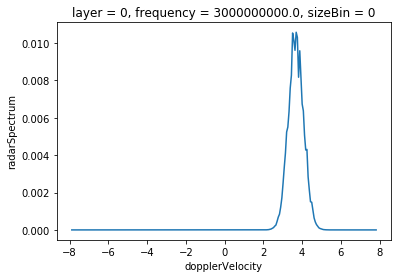

In [45]:
spectral.results.radarSpectrum.isel(layer=0).plot()



In [43]:

pam2.instruments.simple.results.radarReflectivty.compute()

momentsNPeaks 2
momentsNPeaks 2
momentsNPeaks 2
momentsNPeaks 2
momentsNPeaksmomentsNPeaks 2
 2
momentsNPeaks 2
momentsNPeaks 2
momentsNPeaks 2
momentsNPeaks 2


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/pamtra2/instruments/radar.py:368: RuntimeWarning: invalid value encountered in log10
  radarReflectivity = 10 * np.log10(moments[:, 0, :])


(<xarray.DataArray 'radarReflectitivty' (frequency: 1, layer: 10)>
 array([[-19.96824 ,  10.492808,  13.501155,  15.261416,  16.510478,
          17.479383,  18.271065,  18.94044 ,  19.52029 ,  20.03176 ]])
 Coordinates:
   * layer      (layer) int64 0 1 2 3 4 5 6 7 8 9
   * frequency  (frequency) float64 3e+09
     sizeBin    int64 0,
 <xarray.DataArray 'radarReflectivity' (peak: 2, layer: 10, frequency: 1)>
 array([[[-19.869214],
         [       nan],
         [       nan],
         [ 15.360339],
         [ 16.609367],
         [       nan],
         [       nan],
         [ 19.039228],
         [ 19.619044],
         [ 20.130482]],
 
        [[       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan],
         [       nan]]])
 Coordinates:
   * layer      (layer) int64 0 1 2 3 4 5 6 7 8 9
   * frequency  (frequency) float64 3e+09
     sizeBin    

In [14]:
res = pam2.instruments.spectral.results.radarReflectivity.compute()
print(res)

momentsNPeaks 2


/Volumes/User/mmaahn/anaconda/envs/python3/lib/python3.6/site-packages/pamtra2/instruments/radar.py:368: RuntimeWarning: invalid value encountered in log10
  radarReflectivity = 10 * np.log10(moments[:, 0, :])


<xarray.DataArray 'radarReflectivity' (layer: 1, frequency: 1)>
array([[9.942638]])
Coordinates:
  * layer      (layer) int64 0
  * frequency  (frequency) float64 3e+09
    sizeBin    int64 0
    peak       int64 1